# Evaluation of mapping performance of `moscot.spatiotemporal` applied to the MOSTA dataset

Imports mapping results after running the grid search using `run_mosta_st_map.py`.


In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys

In [3]:
from datetime import datetime
import numpy as np
from copy import copy
import pickle as pkl
import glob

import scanpy as sc
import squidpy as sq
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import mplscience
mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

## Dependencies

Requires running:

1. `0_Data_preparation/ZP_2023-04-20_spatiotemporal_fullembryo-preprocess.ipynb`: creates `mouse_embryo_all_stage_renormalized.h5ad`
2. `1_Cell_type_transition_analysis/0_grid_search`: creates `.csv` accuracy files


## Set parameters

In [5]:
sys.path.insert(
    0, "../../../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "space/spatiotemporal"
DATA_DIR = DATA_DIR / "space/spatiotemporal"


## Load processed

In [6]:
adata_six = sc.read(DATA_DIR / "mouse_embryo_all_stage_renormalized.h5ad")

In [7]:
tps = adata_six.obs["time"].unique()
tps_couple = [[i, i+1] for i in tps[:-1]]

## Load scores

In [8]:
filenames = glob.glob(str(DATA_DIR) + "/output/*.csv")

In [9]:
res = pd.DataFrame(columns=["tp_ind", "tp","rank","gamma","epsilon","alpha","score", "type"])
for file in filenames:
    split_ = file.split("/")[-1].split("_")
    epsilon = split_[-9]
    rank = split_[-7]
    gamma = split_[-5]
    alpha = split_[-3]
    tp = split_[-1].split(".")[0]
    df = pd.read_csv(file)
    for row in df.values:
        if row[1] > 0:
            df_ = pd.DataFrame.from_dict({
                "tp_ind":[int(tp)],
                "tp":[f"E{tps_couple[int(tp)][0]}-E{tps_couple[int(tp)][1]}"],
                "rank":[rank],
                "gamma":[gamma],
                "epsilon":[epsilon],
                "alpha":[alpha],
                "score":[row[1]],
                "marginals":[row[0]]
            })
            res = pd.concat([res, df_])
    

In [10]:
res = res[res["marginals"] == "gr marginals"]
res["type"] = "SpatioTemporal"
res.loc[res["alpha"] == "0.0", "type"] = "Temporal"

In [11]:
res["score"] = res["score"].astype(float)
res = res.reset_index()

In [12]:
res_max = res.loc[res.groupby(["tp", "type"])["score"].idxmax(), :].copy()

In [13]:
optimal_alpha = res_max[(res_max["type"] == "SpatioTemporal")][["tp_ind", "tp", "alpha"]]
optimal_alpha.sort_values(by="tp_ind")["alpha"].values

array(['0.4', '0.99', '0.4', '0.8', '0.8', '0.6', '0.99'], dtype=object)

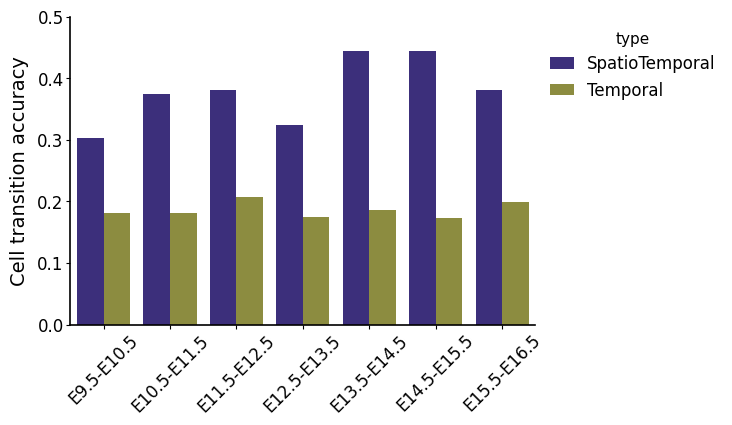

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))
ax = sns.barplot(
    x="tp",
    y="score", 
    hue="type", 
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res_max,
    ax=axs,
    palette=["#332288",
             "#999933", 
            ]
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 0.5)
plt.xlabel("")
plt.ylabel("Cell transition accuracy")
plt.xticks(rotation=45)
plt.savefig(FIG_DIR / "st_accuracy.png", bbox_inches="tight", dpi=300)
plt.show()

In [18]:
colors = sns.blend_palette(["#332288", "#FFFFFF"], 8)
colors

[(0.2, 0.13333333333333333, 0.5333333333333333),
 (0.3129411764705883, 0.2556862745098039, 0.5992156862745098),
 (0.42901960784313725, 0.381437908496732, 0.6669281045751634),
 (0.5419607843137255, 0.5037908496732026, 0.7328104575163399),
 (0.6580392156862744, 0.6295424836601307, 0.8005228758169934),
 (0.7709803921568628, 0.7518954248366013, 0.8664052287581699),
 (0.8870588235294117, 0.8776470588235293, 0.9341176470588235),
 (1.0, 1.0, 1.0)]

In [19]:
res["alpha"].unique()

array(['0.8', '0.2', '0.0', '0.4', '0.99', '0.9', '0.6'], dtype=object)

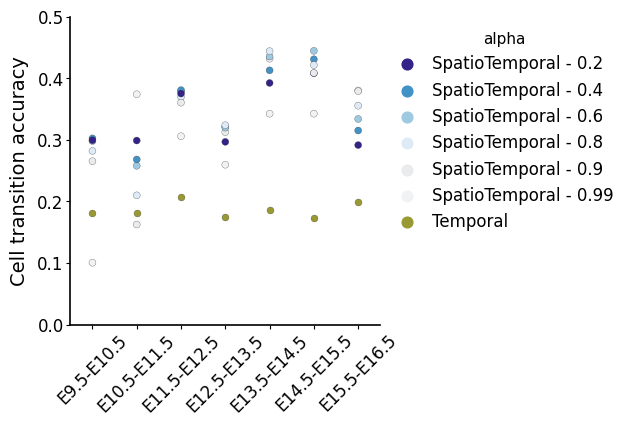

In [20]:
hue_order = ['0.2', '0.4', '0.6', '0.8', '0.9', '0.99', '0.0']
fig, axs = plt.subplots(1, 1, figsize=(4,4))
ax = sns.stripplot(
    x="tp",
    y="score", 
    hue="alpha", 
    hue_order=hue_order[:-1],
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res[res["alpha"] != "0.0"],
    ax=axs,
    palette=["#332288", "#4292C6",  "#9ECAE1", "#DEEBF7", "#E9EBEC", "#F1F2F3"],
    linewidth=.2,
    size=5,
    jitter=False
)

ax = sns.stripplot(
    x="tp",
    y="score", 
    hue="alpha", 
    # hue_order=hue_order,
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res[res["alpha"] == "0.0"],
    ax=axs,
    palette=["#999933", "#998844"],
    linewidth=.2,
    size=5,
    jitter=False
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
leg = ax.axes.get_legend()
new_labels = [
    "SpatioTemporal - 0.2",
    "SpatioTemporal - 0.4",
    "SpatioTemporal - 0.6",
    "SpatioTemporal - 0.8",
    "SpatioTemporal - 0.9",
    "SpatioTemporal - 0.99",
    "Temporal", 
    
]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
    
plt.xlabel("")
plt.ylim(0, 0.5)
plt.ylabel("Cell transition accuracy")
plt.xticks(rotation=45)
plt.savefig(FIG_DIR / "st_accuracy_alpha_prior.png", bbox_inches="tight", dpi=300)
plt.show()